# Twitter SensIA

Para realizar este proyecto haremos uso de los siguientes paquetes de Python:
* _[_NLTK_](http://pandas.pydata.org/)_: herramienta para el análisis de datos.
* _[_TextBlob_](https://textblob.readthedocs.io/en/dev/)_: herramienta para procesar datos de texto.
* _[_Re_](https://docs.python.org/es/3/library/re.html)_: operaciones con expresiones regulares.
* _[_CSV_](https://docs.python.org/3/library/csv.html)_: herramienta para leer y escribir csv.
* _[_Pandas_](http://pandas.pydata.org/)_: herramienta para el análisis de datos.

Los paquetes _NLTK_ y _TextBlob_ han de ser instalados:

In [1]:
!pip install nltk
!pip install textblob

A continuación, importamos todos los paquetes necesarios

In [2]:
#Apartado 2: Eliminar palabras que no aportan información
import csv
import re
import nltk

#Descargamos las ultimas versiones para que funcione correctamente
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#Apartado 3: Etiquetado de datos
from textblob import TextBlob

#Apartado 4
import pandas

#Apartado 5
#Apartado 6
#Apartado 7

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot
import matplotlib.pyplot as pyplot
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import naive_bayes
from sklearn import tree
from sklearn import neighbors
from collections import Counter

# Metodología

### Apartado 1. Recopilación de datos

Hemos recopilado 50.000 tweets que pueden tener un sentimiento positivo, negativo o neutro. Los hemos obtenido a través de [_Kaggle_](https://www.kaggle.com/datasets/kazanova/sentiment140) y los hemos almacenado en el fichero DatosRecopilados.csv.

### Apartado 2. Limpieza de texto

Creamos una función _limpiar_texto_ que, a partir de un tweet original, obtiene un texto limpio sin stop words, menciones, hastags, URLs y cualquier otro simbolo extraño utilizando técnicas de lematización y tokenización.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def limpiar_texto(texto):
    # Eliminamos elementos que no nos sirven
    texto = re.sub(r'http\S+', '', texto)  # eliminamos URLs
    texto = re.sub(r'#\w+', '', texto)  # eliminamos hashtags
    texto = re.sub(r'@\w+', '', texto)  # eliminamos menciones
    texto = re.sub(r'[^\w\s]', '', texto)  # eliminamos otros símbolos extraños
    
    # Convertimos el texto a minúsculas
    texto = texto.lower()
    
    # Tokenización
    tokens = word_tokenize(texto)
    
    # Eliminamos stop words y lematizamos
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    palabras_limpias = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Palabras limpias a una sola cadena de texto
    texto_limpio = ' '.join(palabras_limpias)
    
    return texto_limpio

### Apartado 3. Etiquetado de texto

Creamos una función que sirva para poder etiquetar el texto que hemos limpiado previamente utilizando la libreria _TextBlob_

In [5]:
def etiquetar(texto):
    # Creamos un objeto TextBlob con el texto a analizar
    blob = TextBlob(texto)
    # Valor del análisis de sentimiento
    sentimiento = blob.sentiment.polarity
    # En función del análisis de sentimiento, etiquetamos
    if sentimiento >= 0.7:
        etiqueta = "Muy feliz"
    elif sentimiento >= 0.2:
        etiqueta = "Contento"
    elif sentimiento >= -0.2:
        etiqueta = "Neutro"
    elif sentimiento >= -0.7:
        etiqueta = "Molesto"
    else:
        etiqueta = "Hater"
    return etiqueta

También crearemos una función a la que le introduces el nombre del archivo csv que tenga los datos recopilados y limpios y etiqueta cada linea con su sentimiento correspondiente. La función creará un csv con el nombre indicado que contiene dos columnas nuevas, una para cada texto limpio y otra para la etiqueta correspondiente.

In [6]:
def etiquetado_datos(input_file, output_file):
    with open(input_file, 'r') as file:
        #Leemos los datos delimitados por ;
        reader = csv.reader(file, delimiter=';')
        #Obtenemos todas las filas
        rows = list(reader)
        #Nos quedamos con la cabecera y le añadimos las 2 nuevas columnas
        header = rows[0]
        header.append('Texto limpio')
        header.append('Etiquetado')
        for i in range(1, len(rows)):
            # Usamos la columna en la cuál está el texto en bruto
            valor_columna = rows[i][1]  
            # Limpiamos el texto para que pueda ser analizado
            texto_limpio = limpiar_texto(valor_columna)
            # Lo etiquetamos
            texto_etiquetado = etiquetar(texto_limpio)
            # Añadimos los nuevos valores
            rows[i].append(texto_limpio) 
            rows[i].append(texto_etiquetado)  

    # Guardamos los cambios en un nuevo archivo csv
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerows(rows)

#### Añadir datos al csv

A continuación, procesaremos todos los datos de prueba almcenados en "DatosRecopilados.csv" con las dos funciones realizadas y los almacenaremos en un archivo CSV llamado "DatosFinales.csv".

In [7]:
etiquetado_datos('DatosRecopilados.csv', 'DatosFinales.csv')

### Apartado 4. Validación de la predicción realizada.

A partir del csv generado en el apartado anterior "DatosFinales.csv" hemos creado el siguiente csv llamado "DatosFinalesRevisados.csv". Así, hemos creado un conjunto de datos etiquetados por un modelo ya existente y corregidos por un humano que usaremos como datos de entrenamiento y prueba en el desarrollo del modelo

Por tanto, leemos nuestro csv corregido con las distintas columnas.

In [8]:
csvDatos = pandas.read_csv('DatosFinalesRevisados.csv', delimiter=';',encoding = 'utf-8', header=0,
                       names=['id', 'mensaje', 'texto_limpio','valor_propuesto'])

#### Seleccion de atributos y objetivos

In [9]:
atributo = csvDatos['texto_limpio'].values.astype('U')   # selección de las columnas de atributos
objetivo = csvDatos['valor_propuesto']  # selección de la columna objetivo

In [10]:
# Usamos CountVectorizer para codificar el texto debido a que es el mejor 
# codificador a la hora de usar cadenas de texto puesto que no son etiquetas ni números
codificador_atributo = CountVectorizer()

# Para codificar el objetivo usamos LabelEncoder debido a que solo puede tomar
# 5 valores, es decir, etiquetas
codificador_objetivo = preprocessing.LabelEncoder()

atributo_codificado = codificador_atributo.fit_transform(atributo)
objetivo_codificado = codificador_objetivo.fit_transform(objetivo)

In [11]:
# Vemos el porcentaje de entradas que tienen las distintas etiquetas
print(pandas.Series(objetivo).value_counts(normalize=True))

Neutro       0.57952
Contento     0.18556
Molesto      0.16602
Muy feliz    0.03742
Hater        0.03148
Name: valor_propuesto, dtype: float64


### Apartado 5. Entrenamiento del modelo

In [12]:
(atributo_entrenamiento, atributo_prueba,
 objetivo_entrenamiento, objetivo_prueba) = model_selection.train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
        atributo_codificado, objetivo_codificado,
        # Valor de la semilla aleatoria, para que el muestreo sea reproducible,
        # a pesar de ser aleatorio
        random_state=12345,
        # Tamaño del conjunto de prueba
        test_size=.33,
        # Estratificamos respecto a la distribución de valores en la variable objetivo
        stratify=objetivo_codificado)

In [13]:
# Comprobamos que el conjunto de prueba contiene el 33 % de los datos, en la misma proporción
# con respecto a la variable objetivo
print('Cantidad de ejemplos de pruebas requeridos:', 50000 * .33)
print('Filas del array de atributos de prueba:', atributo_prueba.shape[0])
print('Longitud del vector de objetivos de prueba:', len(objetivo_prueba))
print('Proporción de clases en el vector de objetivos de prueba:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_prueba)
      ).value_counts(normalize=True))

Cantidad de ejemplos de pruebas requeridos: 16500.0
Filas del array de atributos de prueba: 16500
Longitud del vector de objetivos de prueba: 16500
Proporción de clases en el vector de objetivos de prueba:
Neutro       0.579515
Contento     0.185576
Molesto      0.166000
Muy feliz    0.037455
Hater        0.031455
dtype: float64


In [14]:
# Comprobamos que el conjunto de entrenamiento contiene el resto de los datos, en la misma
# proporción con respecto a la variable objetivo
print('Cantidad de ejemplos de entrenamiento requeridos:', 50000 * .67)
print('Filas del array de atributos de entrenamiento:', atributo_entrenamiento.shape[0])
print('Longitud del vector de objetivos de entrenamiento:', len(objetivo_entrenamiento))
print('Proporción de clases en el vector de objetivos de entrenamiento:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_entrenamiento)
      ).value_counts(normalize=True))

Cantidad de ejemplos de entrenamiento requeridos: 33500.0
Filas del array de atributos de entrenamiento: 33500
Longitud del vector de objetivos de entrenamiento: 33500
Proporción de clases en el vector de objetivos de entrenamiento:
Neutro       0.579522
Contento     0.185552
Molesto      0.166030
Muy feliz    0.037403
Hater        0.031493
dtype: float64


In [15]:
nuevos_ejemplos = pandas.DataFrame([['im really sick fever'],
                                    ['im happy family friends']], columns=['texto_limpio'])
nuevos_ejemplos

,texto_limpio
0,im really sick fever
1,im happy family friends


### Prueba Naive Bayes

In [16]:
clasif_NB = naive_bayes.MultinomialNB(alpha=0.5)
clasif_NB.fit(atributo_entrenamiento, objetivo_entrenamiento)

MultinomialNB(alpha=0.5)

In [17]:
predicciones = clasif_NB.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Molesto', 'Contento'], dtype=object)

In [18]:
clasif_NB.score(atributo_prueba, objetivo_prueba)

0.6743030303030303

### Prueba Árboles de Decisión

In [19]:
clasif_CART = tree.DecisionTreeClassifier(
    max_depth=10,  # máxima profundidad del árbol
    random_state=54321  # semilla aleatoria, para que el código sea reproducible
)
clasif_CART.fit(atributo_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=10, random_state=54321)

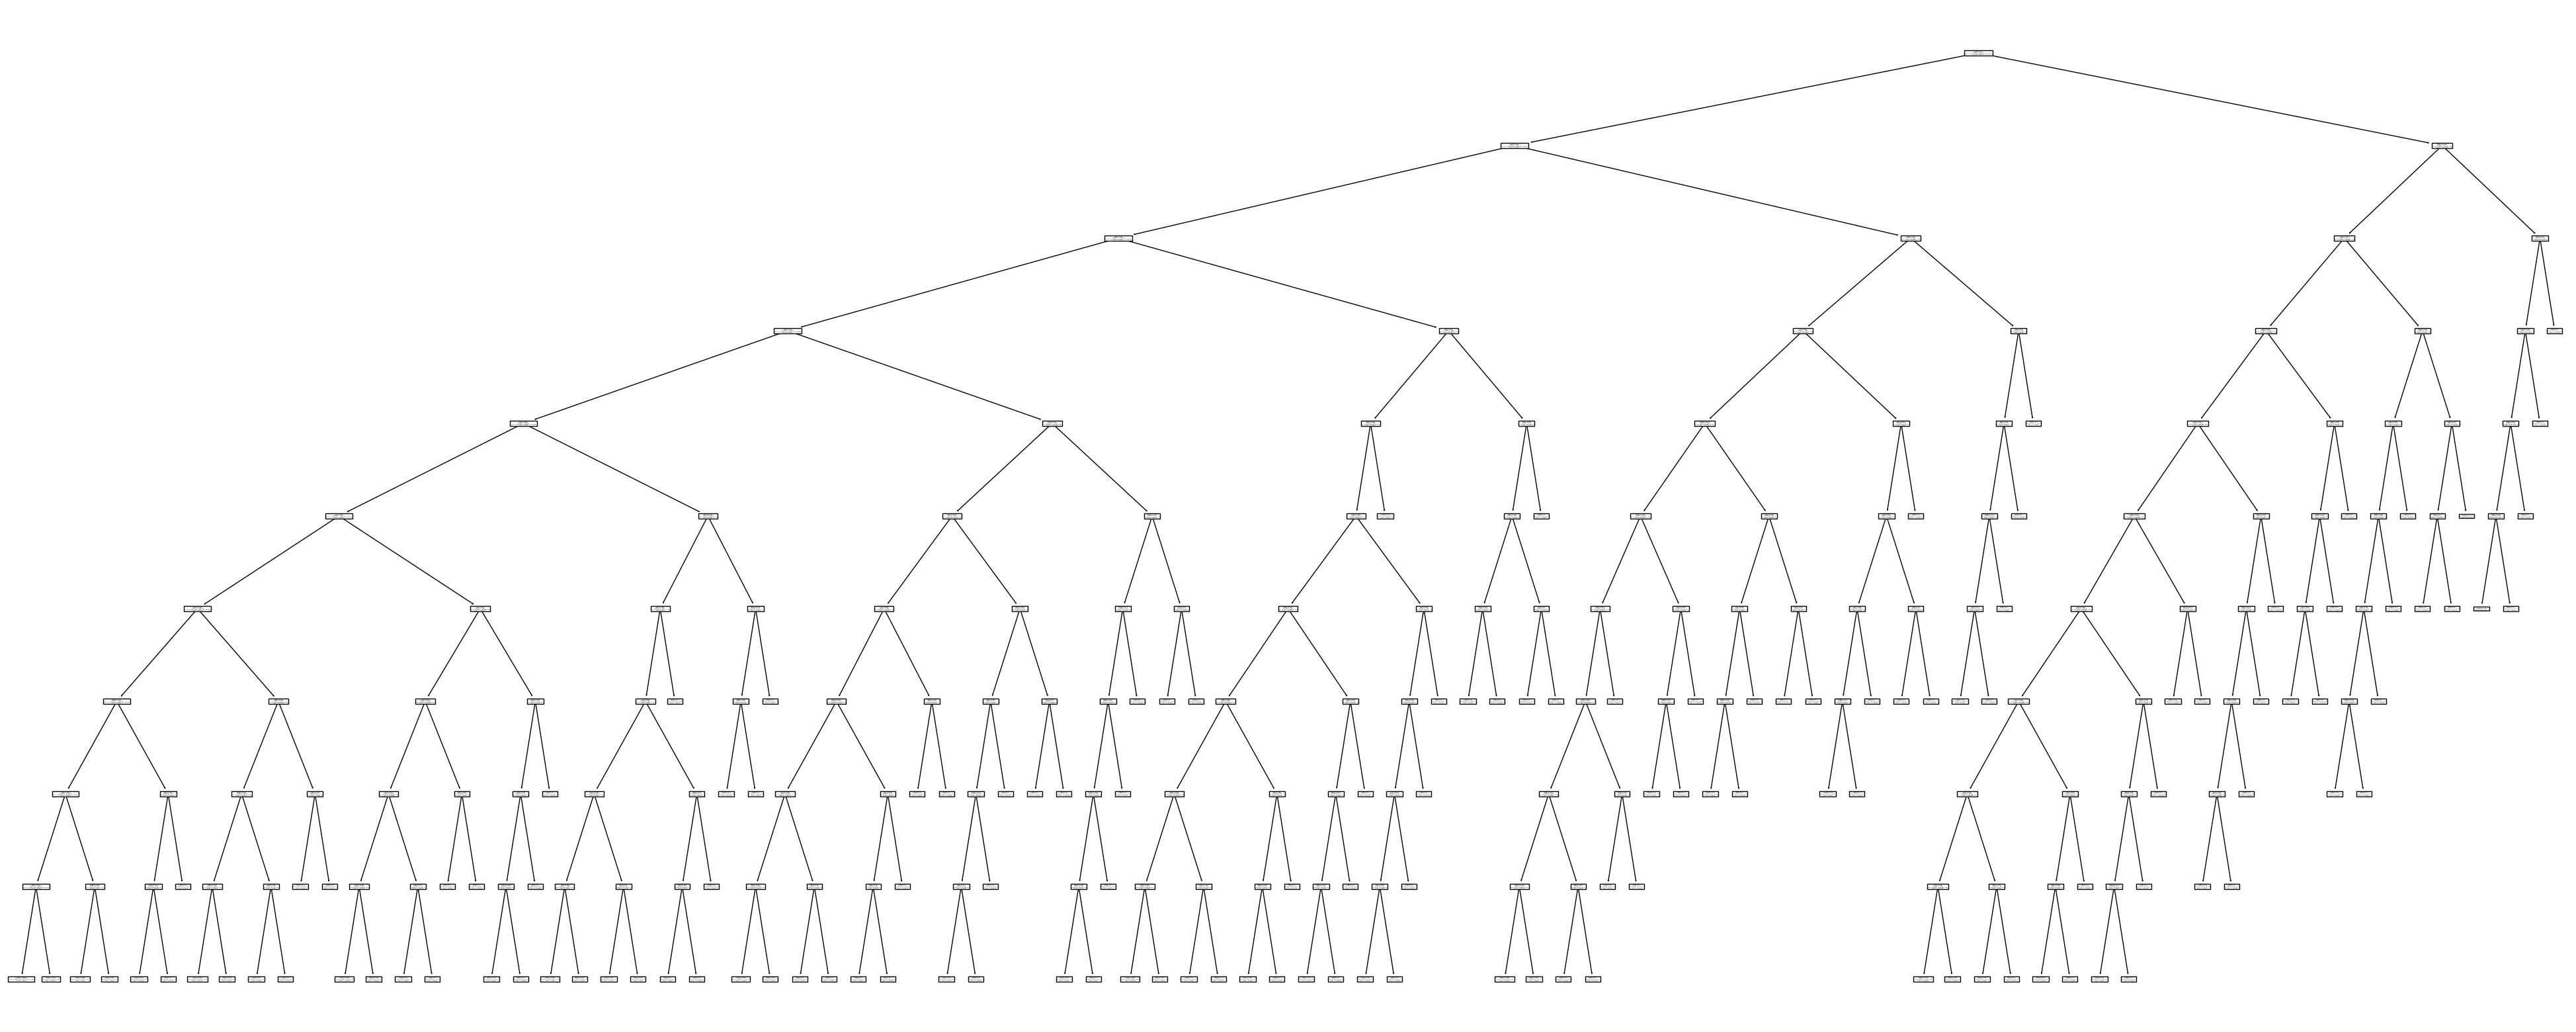

In [20]:
pyplot.figure(figsize=(50, 20))  # Anchura y altura del gráfico
árbol = tree.plot_tree(clasif_CART,
                       feature_names=codificador_atributo.get_feature_names_out(),
                       class_names=codificador_objetivo.classes_)

In [21]:
predicciones = clasif_CART.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Hater', 'Neutro'], dtype=object)

In [22]:
clasif_CART.score(atributo_prueba, objetivo_prueba)

0.6644848484848485

### Prueba KNN

In [23]:
clasif_kNN = neighbors.KNeighborsClassifier(
    n_neighbors=5,  # Número de vecinos a considerar
    metric='euclidean'  # Distancia de Hamming como métrica de cercanía:
                      # fracción de atributos con valores distintos
)
clasif_kNN.fit(atributo_entrenamiento, objetivo_entrenamiento)

KNeighborsClassifier(metric='euclidean')

In [24]:
distancias, vecinos = clasif_kNN.kneighbors(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))

In [25]:
# Vecinos más cercanos y distancia a ellos del primer ejemplo nuevo
print("Primer ejemplo nuevo:")
print(nuevos_ejemplos.iloc[[0]])
print()
print("5 vecinos más cercanos:")
print(pandas.DataFrame(codificador_atributo.inverse_transform(atributo_entrenamiento[vecinos[0]]),
                       index=vecinos[0]).assign(
    distancia=distancias[0],
    clase=codificador_objetivo.inverse_transform(objetivo_entrenamiento[vecinos[0]])
))

Primer ejemplo nuevo:
           texto_limpio
0  im really sick fever

5 vecinos más cercanos:
            0       1      2          3  distancia  clase
4220       im  really   sick      tummy   1.414214  Hater
6131       im    sick  fever  todayhave   1.414214  Hater
9772   really    sick   None       None   1.414214  Hater
11994  really    sick   None       None   1.414214  Hater
8590       im    sick   None       None   1.414214  Hater


In [26]:
# Vecinos más cercanos y distancia a ellos del segundo ejemplo nuevo
print("Segundo ejemplo nuevo:")
print(nuevos_ejemplos.iloc[[1]])
print()
print("5 vecinos más cercanos:")
print(pandas.DataFrame(codificador_atributo.inverse_transform(atributo_entrenamiento[vecinos[1]]),
                       index=vecinos[1]).assign(
    distancia=distancias[1],
    clase=codificador_objetivo.inverse_transform(objetivo_entrenamiento[vecinos[1]])
))

Segundo ejemplo nuevo:
              texto_limpio
1  im happy family friends

5 vecinos más cercanos:
           0  distancia      clase
1020      im   1.414214     Neutro
1657   happy   1.414214  Muy feliz
8089      im   1.414214     Neutro
8016   happy   1.414214  Muy feliz
21370  happy   1.414214  Muy feliz


In [27]:
predicciones = clasif_kNN.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Hater', 'Muy feliz'], dtype=object)

In [28]:
clasif_kNN.score(atributo_prueba, objetivo_prueba)

0.6569090909090909

### Validación cruzada de los métodos

In [29]:
#Para Naives Bayes
#creo un diccionario vacio
cv_scores_NB = {}
for k in range(1,11):
    #creo una instancia de modelo Naives Bayes para cada valor de suavizado (del 1 al 10, 11 porque python no coge el último)
    clasif_NB = naive_bayes.MultinomialNB(alpha=k)
    #guardo en cv_scores el resultado de cross_val_score que va hacer una validacion cruzada para cada suavizado
    cv_scores = model_selection.cross_val_score(clasif_NB,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    #lo guardo en el diccionario clave=suavizado, valor=media del resultado de la validacion cruzada para ese suavizado.
    cv_scores_NB[k] = cv_scores.mean()
    
print(cv_scores_NB)
mejor_k_NB = max(cv_scores_NB, key=cv_scores_NB.get)
print(f'Mejor suavizado: {mejor_k_NB}')

{1: 0.6601492537313434, 2: 0.631044776119403, 3: 0.6148059701492538, 4: 0.6080597014925373, 5: 0.6031044776119403, 6: 0.5996119402985075, 7: 0.5972835820895522, 8: 0.5952835820895522, 9: 0.5939402985074628, 10: 0.5925970149253731}
Mejor suavizado: 1


In [30]:
#Para arboles de decisión con CART
#Tarda entre 3 y 5 minutos
cv_scores_CART = {}
for p in range(1,11):
    clasif_CART = tree.DecisionTreeClassifier(max_depth=p)
    cv_scores = model_selection.cross_val_score(clasif_CART,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    cv_scores_CART[p] = cv_scores.mean()
print(cv_scores_CART)
mejor_p_CART = max(cv_scores_CART, key=cv_scores_CART.get)
print(f'Mejor profundidad: {mejor_p_CART}')

{1: 0.585731343283582, 2: 0.596865671641791, 3: 0.6065074626865672, 4: 0.6206268656716418, 5: 0.6284179104477612, 6: 0.6361492537313433, 7: 0.6434925373134328, 8: 0.652955223880597, 9: 0.6578507462686567, 10: 0.6642089552238806}
Mejor profundidad: 10


In [31]:
#Para modelo kNN
cv_scores_kNN = {}
for k in range(1,11):
    clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean') 
    cv_scores = model_selection.cross_val_score(clasif_kNN,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    cv_scores_kNN[k] = cv_scores.mean()
print(cv_scores_kNN)
mejor_k_kNN = max(cv_scores_kNN, key=cv_scores_kNN.get)
print(f'Mejor número de vecinos: {mejor_k_kNN}')

{1: 0.6689253731343283, 2: 0.6727462686567163, 3: 0.6600298507462686, 4: 0.6707164179104478, 5: 0.6536119402985074, 6: 0.6624179104477612, 7: 0.6519701492537313, 8: 0.6552835820895522, 9: 0.6479402985074627, 10: 0.650686567164179}
Mejor número de vecinos: 2


### Apartado 6. Predicción de tweets

In [32]:
clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors=mejor_k_kNN, metric='euclidean')
clasif_kNN.fit(atributo_entrenamiento, objetivo_entrenamiento)
clasif_kNN.score(atributo_prueba, objetivo_prueba)

0.675939393939394

El acierto es del 67%

### Apartado 7. Análisis de tweets de personajes públicos

Tomaremos como Hater al usuario @kirawontmiss que es un personaje público con más de 1 millón de seguidores que suele criticar noticias actuales

In [33]:
mensajes_negativos = pandas.DataFrame([
['why the FUCK are we even still paying bills?? the world is literally ending'],
['YEAH THIS IS GETTING SO BAD.. WHAT THE FUCK DO U MEAN HAZARDOUS ??'],
['LMFAOOO pixar deleted the tweet'],
['yeah society is FINISHED.. mfs are really comparing wildfires'],
['this gotta be the worst time to post this tweet LMAOO https://twitter.com/pixar/status/1666520608107298817'],
['who the fuck owns Kick they are out here giving out NBA contracts'],
['i had no problem with eminem until this horrible video dropped'],
['SO THIS WASNT A JOKE???'],
['FINALLY WE ARE FREE'],
['nothing could’ve prepared me for the ending'],
['why the fuck don’t they jump over moving cars like this'],
['LMAOO bro had the entire theater laughing'],
['usually people hate when someone does this im surprised he got everyone laughing 😭'],
['do you know how unlucky you have to be for some shit like this to happen to you LMAOO'],
['for $3499 that shit better let me see into the future wtf'],
['why she dressed like a condom before you put it on LMAOOO'],
['LMFAOOOOOO boruto didn’t influence shit'],
['world war 2 is over.. y’all don’t have to eat like this anymore'],
['he’s useless as fuck'],
['WHAT THE FUCKKK THIS SHlT IS A MASTERPIECE'],
['the way drake said embarrassing is exactly how i expected him to say it'],
['why are you holding the drinks like this'],
['Ai is gonna have y’all fucked up'],
['IM NOT MAKING IT'],
['alright its been 7 years who the fuck was behind those clowns costumes back in 2016'],
['this is easily the worst genre of anime'],
['LMFAOOO evil ass laugh'],
['that person gonna watch the movie like this']], columns=['texto_limpio'])
mensajes_negativos_limpios = []
for mensaje in mensajes_negativos.values:
    mensajes_negativos_limpios.append(limpiar_texto(mensaje[0]))
mensajes_negativos_limpios1 = pandas.DataFrame(mensajes_negativos_limpios,columns=['texto_limpio'])

Tomaremos como usuario positivo al futbolista @ErlingHaaland que es un delantero noruego del equipo inglés Manchester City que durante esta temporada ha ganado todo los títulos posibles y ha sido máximo goleador histórico de la liga inglesa, por lo que ha sido un año positivo para él.

In [34]:
mensajes_positivos = pandas.DataFrame([
['One more @BVB'],
['Honoured to win such an incredibly prestigious award  @theofficialfwa Thank you to all those who voted for me. Obviously, this wouldnt have been possible without the unbelievable support I have from everyone at @ManCity'],
['Thanks to everyone for the support and love, these memories will last a lifetime!'],
['Me and my baby'],
['Always give your best. Always believe. It pays off. CMON CITY! '],
['💯 Focus on tomorrow'],
['Thank you! Busy morning 😅'],
['Thank you everyone! 🙌🏻'],
['Thank you 🙏🏻 and congratulations to back-to-back winner @samkerr1, amazing achievement!'],
['Thank you 🙏🏻'],
['It’s all in our hands... Can’t wait for the game next week! 🔜'],
['Job done, looking forward to Tuesday! 👊🏻'],
['Friend: how many league goals have you scored? Me:'],
['@ErlingHaaland was Born to Goal. To celebrate his phenomenal @PremierLeague goalscoring record we created a unique phenomenon in the skies of Manchester. #Force9 #nikefc'],
['A night to remember! 💙'],
['35 Premier League goals 🤩 A big thank you to everyone for the support, nothing happens without you all, we dont stop here! 💙'],
['We fight!'],
['Cannot. Wait. 🔵 #mancity'],
['Through to the final! 🔵 #mancity #FACup'],
['Destiny is ALL 🔵 #mancity'],
['Semis here we come! 💙 thanks to all our travelling fans for the support #mancity #UCL'],
['Big week of results! 🔵 #mancity'],
['Me and my magic potion 🥛💪🏻'],
['Nothing but pure love for this competition! 🔵 #mancity #UCL'],
['Wishing everyone celebrating a Happy Easter! 🐰 I hope you enjoy the special day with your loved ones! 🙏🏻'],
['Back on the pitch! ⚡️🔵 #mancity'],
['Good old days'],
['Wishing everyone a happy, healthy & bright #ChineseNewYear! ✨'],
['Positive spirit! 🔵 #mancity'],
['What a team performance! Fans were unreal, thanks for being our 12th man 💙 #mancity'],
['Very happy to get this achievement where it all started for me. 20 PL goals, and looking forward to many more! ☝🏻🤖🔵 #mancity'],
['A special game for me last night, was great to be back to Leeds 🔵 #mancity']],columns=['texto_limpio'])
mensajes_positivos_limpios = []
for mensaje in mensajes_positivos.values:
    mensajes_positivos_limpios.append(limpiar_texto(mensaje[0]))
mensajes_positivos_limpios1 = pandas.DataFrame(mensajes_positivos_limpios,columns=['texto_limpio'])

In [35]:
predicciones_negativas = clasif_kNN.predict(codificador_atributo.transform(mensajes_negativos_limpios1['texto_limpio']))
array_negativo = codificador_objetivo.inverse_transform(predicciones_negativas)
array_negativo

array(['Molesto', 'Molesto', 'Neutro', 'Neutro', 'Neutro', 'Molesto',
       'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Molesto', 'Neutro',
       'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro',
       'Molesto', 'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro',
       'Molesto', 'Hater', 'Neutro', 'Neutro'], dtype=object)

In [36]:
predicciones_positivas = clasif_kNN.predict(codificador_atributo.transform(mensajes_positivos_limpios1['texto_limpio']))
array_positivo = codificador_objetivo.inverse_transform(predicciones_positivas)
array_positivo

array(['Neutro', 'Contento', 'Contento', 'Neutro', 'Neutro', 'Neutro',
       'Contento', 'Contento', 'Contento', 'Contento', 'Neutro', 'Neutro',
       'Neutro', 'Neutro', 'Muy feliz', 'Neutro', 'Neutro', 'Neutro',
       'Neutro', 'Neutro', 'Contento', 'Neutro', 'Neutro', 'Contento',
       'Muy feliz', 'Neutro', 'Muy feliz', 'Muy feliz', 'Neutro',
       'Contento', 'Muy feliz', 'Neutro'], dtype=object)

In [37]:
diccionario_negativos = dict(Counter(array_negativo))
diccionario_positivos = dict(Counter(array_positivo))
claves_negativas = list(diccionario_negativos.keys())
claves_positivas = list(diccionario_positivos.keys())
valores_negativos = list(diccionario_negativos.values())
valores_positivos = list(diccionario_positivos.values())

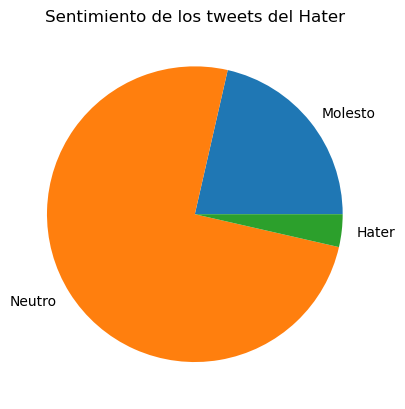

In [38]:
pyplot.pie(valores_negativos, labels=claves_negativas)
pyplot.title('Sentimiento de los tweets del Hater')
pyplot.show()

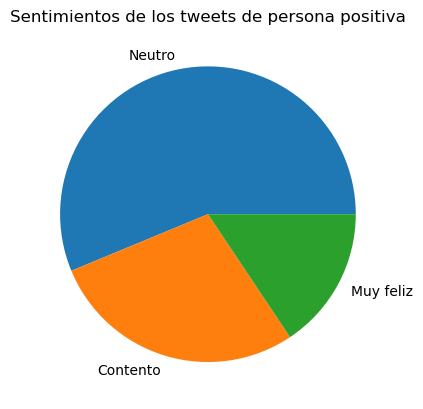

In [39]:
pyplot.pie(valores_positivos, labels=claves_positivas)
pyplot.title('Sentimientos de los tweets de persona positiva')
pyplot.show()